Machine Learning Nanodegree Capstone Project
=============

This is my final model for the digit recognition from SVHN images project


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from six.moves import range
%matplotlib inline

In [2]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (45000, 32, 32) (45000,)
Validation set (6000, 32, 32) (6000,)
Test set (15000, 32, 32) (15000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 32
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (45000, 32, 32, 1) (45000, 10)
Validation set (6000, 32, 32, 1) (6000, 10)
Test set (15000, 32, 32, 1) (15000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's add another convolutional layer, followed by one fully connected layer. Experimenting with batch_size=32

In [5]:
batch_size = 32
patch_size = 5
depth = 16
num_hidden = 128
#beta_regul = 1e-3
drop_out = 0.95

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  
  layer3_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data, keep_prob):
    # C1 input 32 x 32 x 1
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    print(bias1.get_shape())
    # S2 input 28 x 28 x 16
    pool2 = tf.nn.avg_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    print(pool2.get_shape())
    # C3 input 14 x 14 x 16
    conv3 = tf.nn.conv2d(pool2, layer2_weights, [1, 1, 1, 1], padding='VALID')
    bias3 = tf.nn.relu(conv3 + layer2_biases)
    print(bias3.get_shape())
    # S4 input 10 x 10 x 16
    pool4 = tf.nn.avg_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    print(pool4.get_shape())
    # C5 input 5 x 5 x 16
    conv5 = tf.nn.conv2d(pool4, layer3_weights, [1, 1, 1, 1], padding='VALID')
    bias5 = tf.nn.relu(conv5 + layer3_biases)
    print(bias5.get_shape())
    # Dropout
    hidden = tf.nn.dropout(bias5, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    print(reshape)
    #F6 input 1x1x128
    hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    return tf.matmul(hidden, layer5_weights) + layer5_biases

  # Training computation.
  logits = model(tf_train_dataset, drop_out)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.95, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
  #optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
  test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))

(32, 28, 28, 16)
(32, 14, 14, 16)
(32, 10, 10, 16)
(32, 5, 5, 16)
(32, 1, 1, 128)
Tensor("Reshape:0", shape=(32, 128), dtype=float32)
(6000, 28, 28, 16)
(6000, 14, 14, 16)
(6000, 10, 10, 16)
(6000, 5, 5, 16)
(6000, 1, 1, 128)
Tensor("Reshape_1:0", shape=(6000, 128), dtype=float32)
(15000, 28, 28, 16)
(15000, 14, 14, 16)
(15000, 10, 10, 16)
(15000, 5, 5, 16)
(15000, 1, 1, 128)
Tensor("Reshape_2:0", shape=(15000, 128), dtype=float32)


In [6]:
num_steps = 80001
accuracy_plot = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
      minibatch_accuracy = accuracy(predictions, batch_labels)
      validation_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      accuracy_plot.append((minibatch_accuracy,validation_accuracy,l))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.123059
Minibatch accuracy: 12.5%
Validation accuracy: 10.7%
Minibatch loss at step 500: 0.795039
Minibatch accuracy: 71.9%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 0.300794
Minibatch accuracy: 84.4%
Validation accuracy: 80.8%
Minibatch loss at step 1500: 0.584539
Minibatch accuracy: 81.2%
Validation accuracy: 83.6%
Minibatch loss at step 2000: 0.113191
Minibatch accuracy: 96.9%
Validation accuracy: 86.1%
Minibatch loss at step 2500: 0.269192
Minibatch accuracy: 87.5%
Validation accuracy: 86.2%
Minibatch loss at step 3000: 0.272185
Minibatch accuracy: 90.6%
Validation accuracy: 85.8%
Minibatch loss at step 3500: 0.532803
Minibatch accuracy: 84.4%
Validation accuracy: 86.4%
Minibatch loss at step 4000: 0.046885
Minibatch accuracy: 96.9%
Validation accuracy: 86.1%
Minibatch loss at step 4500: 0.101700
Minibatch accuracy: 96.9%
Validation accuracy: 87.4%
Minibatch loss at step 5000: 0.107931
Minibatch accuracy: 96.9%
Validation accurac

Batch_size=16

In [11]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 128
#beta_regul = 1e-3
drop_out = 0.95

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  
  layer3_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data, keep_prob):
    # C1 input 32 x 32 x 1
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    print(bias1.get_shape())
    # S2 input 28 x 28 x 16
    pool2 = tf.nn.avg_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    print(pool2.get_shape())
    # C3 input 14 x 14 x 16
    conv3 = tf.nn.conv2d(pool2, layer2_weights, [1, 1, 1, 1], padding='VALID')
    bias3 = tf.nn.relu(conv3 + layer2_biases)
    print(bias3.get_shape())
    # S4 input 10 x 10 x 16
    pool4 = tf.nn.avg_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    print(pool4.get_shape())
    # C5 input 5 x 5 x 16
    conv5 = tf.nn.conv2d(pool4, layer3_weights, [1, 1, 1, 1], padding='VALID')
    bias5 = tf.nn.relu(conv5 + layer3_biases)
    print(bias5.get_shape())
    # Dropout
    hidden = tf.nn.dropout(bias5, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    print(reshape)
    #F6 input 1x1x128
    hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    return tf.matmul(hidden, layer5_weights) + layer5_biases

  # Training computation.
  logits = model(tf_train_dataset, drop_out)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.95, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
  #optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
  test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))

(16, 28, 28, 16)
(16, 14, 14, 16)
(16, 10, 10, 16)
(16, 5, 5, 16)
(16, 1, 1, 128)
Tensor("Reshape:0", shape=(16, 128), dtype=float32)
(6000, 28, 28, 16)
(6000, 14, 14, 16)
(6000, 10, 10, 16)
(6000, 5, 5, 16)
(6000, 1, 1, 128)
Tensor("Reshape_1:0", shape=(6000, 128), dtype=float32)
(15000, 28, 28, 16)
(15000, 14, 14, 16)
(15000, 10, 10, 16)
(15000, 5, 5, 16)
(15000, 1, 1, 128)
Tensor("Reshape_2:0", shape=(15000, 128), dtype=float32)


In [12]:
num_steps = 100001
accuracy_plot = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
      minibatch_accuracy = accuracy(predictions, batch_labels)
      validation_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      accuracy_plot.append((minibatch_accuracy,validation_accuracy,l))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.343128
Minibatch accuracy: 6.2%
Validation accuracy: 9.4%
Minibatch loss at step 500: 0.549044
Minibatch accuracy: 93.8%
Validation accuracy: 71.5%
Minibatch loss at step 1000: 1.164681
Minibatch accuracy: 62.5%
Validation accuracy: 78.6%
Minibatch loss at step 1500: 0.710528
Minibatch accuracy: 87.5%
Validation accuracy: 78.7%
Minibatch loss at step 2000: 0.368301
Minibatch accuracy: 87.5%
Validation accuracy: 83.2%
Minibatch loss at step 2500: 0.667753
Minibatch accuracy: 87.5%
Validation accuracy: 84.4%
Minibatch loss at step 3000: 0.277265
Minibatch accuracy: 87.5%
Validation accuracy: 83.0%
Minibatch loss at step 3500: 0.346974
Minibatch accuracy: 93.8%
Validation accuracy: 85.3%
Minibatch loss at step 4000: 0.176623
Minibatch accuracy: 93.8%
Validation accuracy: 85.9%
Minibatch loss at step 4500: 0.119880
Minibatch accuracy: 93.8%
Validation accuracy: 86.7%
Minibatch loss at step 5000: 0.292992
Minibatch accuracy: 87.5%
Validation accuracy:

Mean value of validation accuracy is 89.2078772803
Max value of validation accuracy is 90.4833333333


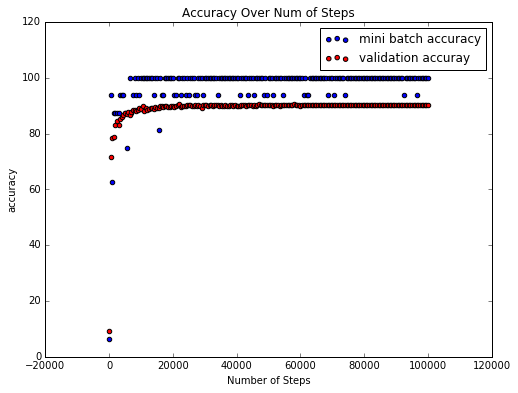

In [35]:
steps = np.arange(201)*500

mini_acc = map(lambda t: t[0], accuracy_plot)
valid_acc = map(lambda t: t[1], accuracy_plot)
mean = np.mean(valid_acc)
max = np.max(valid_acc)

print('Mean value of validation accuracy is', mean)
print('Max value of validation accuracy is', max)

plt.figure(figsize=(8,6), dpi=75)
plt.scatter(steps, mini_acc)
plt.scatter(steps, valid_acc, c='r')

plt.title('Accuracy Over Num of Steps')
plt.legend(['mini batch accuracy', 'validation accuray'])
plt.xlabel('Number of Steps')
plt.ylabel('accuracy')
plt.show()

0.0838742 9.26075e-06


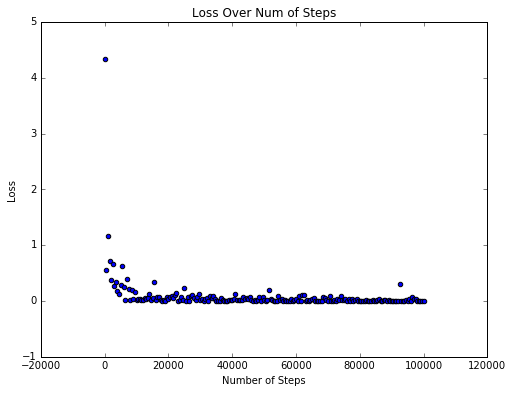

In [27]:
steps = np.arange(201)*500

batch_loss = map(lambda t: t[2], accuracy_plot)
print(np.mean(batch_loss), np.min(batch_loss))

plt.figure(figsize=(8,6), dpi=75)
plt.scatter(steps, batch_loss)

plt.title('Loss Over Num of Steps')
plt.xlabel('Number of Steps')
plt.ylabel('Loss')
plt.show()